# Conditional Regression

this code implement conditional regression method to calculate population density for each cluster

In [1]:
import gdal
import tqdm
import os
import sys
import argparse
import glob
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask as mask
from scipy.optimize import fmin, minimize
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
import multiprocess as mp
import subprocess
import shutil

In [2]:
print('--------------------------------------------------------------------------------------------------')
print('Population data process 7/7: conditional regression to calculate population densities for clusters')
print('--------------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------------
Population data process 7/7: conditional regression to calculate population densities for clusters
--------------------------------------------------------------------------------------------------


In [3]:
#setting up paths for files
#top_folder="/home/dohyungkim/population"
#ISO="PER"
#year="2015"

In [ ]:
# Initialize parser 
my_parser = argparse.ArgumentParser(description='initial input')
my_parser.add_argument('top_folder',metavar='top_folder',type=str,help='working folder')
my_parser.add_argument('ISO',metavar='ISO',type=str,help='3 character country iso code')
my_parser.add_argument('year',metavar='year',type=str,help='population year')
args = my_parser.parse_args()
top_folder = args.top_folder
ISO = args.ISO
year = args.year
if not os.path.isdir(top_folder):
    print('The path specified does not exist')
    sys.exit()

In [4]:
df_info=pd.read_pickle(os.path.join(top_folder,ISO,"df_info.pkl"))
n_component=int(df_info["n_component"])

In [6]:
fb_path=os.path.join(top_folder,ISO,"fb_data")
wp_path=os.path.join(top_folder,ISO,"wp_data")

In [7]:
#read saved dataframes
df_bnd=pd.read_pickle(os.path.join(wp_path,"df_bnd.pkl"))
df_x=pd.read_pickle(os.path.join(top_folder,ISO,"df_x.pkl"))
wp_census_file=os.path.join(wp_path,ISO+"_population_2000_2020.csv")

In [37]:
df_x=df_x.reset_index(drop=True)

In [38]:
m=np.array(df_bnd['mean'])
bnds=np.array([df_bnd['min'],df_bnd['max']])
bnds=bnds.transpose()

In [40]:
#calculate adjustment factor
#applying the adjustment factor to 30m pixels 

In [41]:
#prepare adjustment
fb_file=os.path.join(wp_path,"fb_weight_gmm.tif")
raster=rasterio.open(fb_file)
fb_arr = raster.read(1)
kwargs = raster.profile

In [42]:
tmp_sum=0
for i in range(len(m)):
    tmp_sum+=len(np.where(fb_arr==i+1)[0])*m[i]

In [43]:
wp_census = pd.read_csv(wp_census_file)["P_2015"]
pop_sum=wp_census.sum()
adj_fac=pop_sum/tmp_sum

In [44]:
m=m*adj_fac
bnds=bnds*adj_fac

In [45]:
#dynamically define conditional functions
def make_con_fun(i,w):
    def _con_fun(w):
        return w[i] - w[i-1]
    return _con_fun

In [46]:
#dynamically define conditions
def make_cons(con_fun):
    con = {'type':'ineq', 'fun': con_fun}
    return con

In [47]:
#define multiple linear regression function
def pred(x, w):
    return np.dot(x, w)

In [48]:
con_funs = [make_con_fun(i,m) for i in range(1, n_component)]

In [49]:
cons = [make_cons(con_fun) for con_fun in con_funs]

In [50]:
#prepare x, y data, initialize vector of weights
x = df_x.iloc[:,0:n_component]
y = df_x['y']
w = np.zeros(x.shape[1])
w = m

In [51]:
n_splits=5
kf = KFold(n_splits=n_splits,random_state=None, shuffle=True)

In [52]:
reg_scores=np.zeros(n_splits)           

In [53]:
covars=np.zeros((n_splits,n_component))

In [54]:
print("5 fold conditional regression")

5 fold conditional regression


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1987446363062726
            Iterations: 79
            Function evaluations: 1523
            Gradient evaluations: 78
test score=0.8342060266324358
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1142975631896703
            Iterations: 53
            Function evaluations: 998
            Gradient evaluations: 52
test score=0.8974263545345157
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1413394166685644
            Iterations: 75
            Function evaluations: 1441
            Gradient evaluations: 74
test score=0.8761635543253928
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1347264841781033
            Iterations: 50
            Function evaluations: 950
            Gradient evaluations: 50
test score=0.8812696398148429
Optimization terminated succes

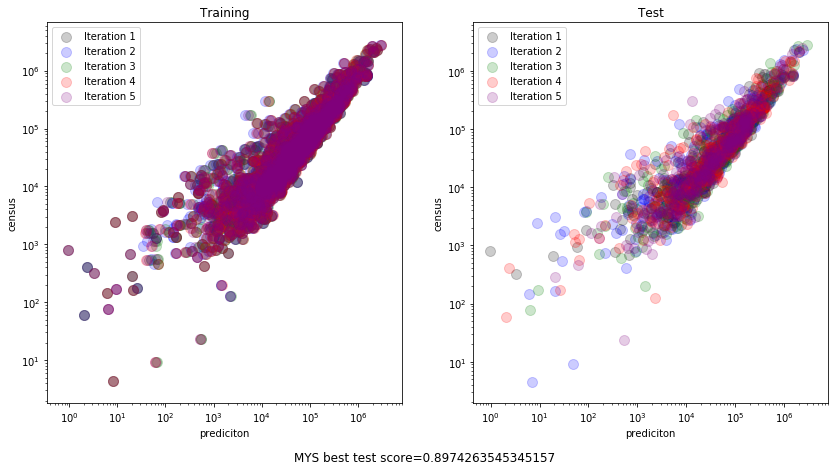

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 7))
colors=['black','blue','green','red','purple','black','blue','green','red','purple']
i=0
for train_index, test_index in kf.split(x):
    
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    #define our loss function
    def loss(_w):
        p = pred(x_train, _w)
        p_test = pred(x_test, _w)
        reg = LinearRegression().fit(p.reshape(-1, 1),y_train)
        reg_score=reg.score(p_test.reshape(-1, 1),y_test)
        rmse=1/reg_score
        return rmse
    
    #use minimize() SLSQP
    nms = minimize(loss, w, method='SLSQP',constraints=cons,bounds=bnds,
                   options={'maxiter': 1000, 'ftol': 1e-12, 'iprint': 1, 
                            'disp': True, 'eps': 1e-12})

    #nms
    ax1.scatter(pred(x_train, nms.x),y_train, c=colors[i],marker='o',s=100,alpha=0.2, label='Iteration ' + str(i+1))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    ax1.set_title('Training')
    ax1.set_xlabel('prediciton')
    ax1.set_ylabel('census')  
    
    ax2.scatter(pred(x_test, nms.x),y_test, c=colors[i],marker='o',s=100,alpha=0.2, label='Iteration ' + str(i+1))
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend(loc='upper left')
    ax2.set_title('Test')
    ax2.set_xlabel('prediciton')
    ax2.set_ylabel('census')  
    
    reg = LinearRegression().fit(pred(x_train, nms.x).reshape(-1, 1), y_train)
    reg_scores[i]=reg.score(pred(x_test, nms.x).reshape(-1, 1), y_test)
    
    covars[i]=nms.x
    print("test score=" + str(reg_scores[i]))
    i=i+1


plt.figtext(0.5, 0.01, ISO + " best test score=" + str(np.max(reg_scores)), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(os.path.join(top_folder,ISO,"conditional_regression.png"), dpi=100)
#plt.show()

In [56]:
#assign with best results
nms =covars[np.argmax(reg_scores)]

In [57]:
tmp_sum=0
for i in range(len(nms)):
    tmp_sum+=len(np.where(fb_arr==i+1)[0])*nms[i]

In [58]:
adj_fac=pop_sum/tmp_sum

In [59]:
nms=nms*adj_fac

In [60]:
df_info["regression_accuracy"]=np.max(reg_scores)
df_info["total_predicted_pop"]=tmp_sum*adj_fac
df_info["total_census_pop"]=pop_sum
df_info.to_pickle(os.path.join(top_folder,ISO,"df_info.pkl"))

In [61]:
#prepare to retile fb_gmm file
gmm_tile_path=os.path.join(fb_path,'gmm_tiles')
if not os.path.exists(gmm_tile_path):
    os.mkdir(gmm_tile_path)
    
pop_tile_path=os.path.join(fb_path,'pop_tiles')
if not os.path.exists(pop_tile_path):
    os.mkdir(pop_tile_path)

In [62]:
del fb_arr

In [63]:
cmd = 'gdal_retile.py -ot float32 -ps 1024 1024 -targetDir '
cmd+= gmm_tile_path
cmd+=' '
cmd+= fb_file
proc = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdout,stderr=proc.communicate()

In [64]:
gmm_tiles=os.listdir(gmm_tile_path)

In [65]:
def save_pop(gmm_tile):
    try:
        gmm_data=rasterio.open(os.path.join(gmm_tile_path,gmm_tile))
        gmm_arr=gmm_data.read(1)
        img_arr=np.zeros(gmm_arr.shape, dtype=np.float32)
        for i in range(len(nms)):
            img_arr[np.where(gmm_arr==i+1)]=nms[i]
        
        with rasterio.open(
            os.path.join(pop_tile_path,gmm_tile),
            'w',
            driver='GTiff',
            height=img_arr.shape[0],
            width=img_arr.shape[1],
            count=1,
            dtype=img_arr.dtype,
            crs=gmm_data.crs,
            transform=gmm_data.transform
        ) as dst:
            dst.write(img_arr, 1)
        
        return(1)
    except:
        return(0)

In [66]:
print("saving final population data")

saving final population data


In [67]:
p = mp.Pool()

In [68]:
results = list(tqdm.tqdm(p.imap_unordered(save_pop, gmm_tiles), total=len(gmm_tiles)))

100%|██████████| 1587/1587 [00:09<00:00, 160.81it/s]


In [69]:
p.close()
p.join()

In [70]:
os.chdir(pop_tile_path)
pop_files=glob.glob(pop_tile_path + '/*.tif')
vrt=gdal.BuildVRT(os.path.join(top_folder,ISO,'population_'+ISO+'.vrt'), pop_files)
vrt.FlushCache()

In [71]:
cmd = 'gdal_translate -of GTiff -co "COMPRESS=LZW" ' 
cmd+= os.path.join(top_folder,ISO,'population_'+ISO+'.vrt ')
cmd+=' '
cmd+= os.path.join(top_folder,ISO,'population_'+ISO+'.tif')
proc = subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
stdout,stderr=proc.communicate()

In [72]:
fb_tile_path=os.path.join(fb_path,'fb_tiles')
out_tile_path=os.path.join(fb_path,"out_tiles") 
shutil.rmtree(wp_path)
shutil.rmtree(fb_tile_path)
shutil.rmtree(out_tile_path)
shutil.rmtree(gmm_tile_path)
shutil.rmtree(pop_tile_path)

In [73]:
df_info

,country_code,year,rf_accuracy,n_component,regression_accuracy,total_predicted_pop,total_census_pop
0,MYS,2015,0.84039,17,0.897426,3.086735e+07,3.086735e+07


In [74]:
print("High resolution population data processing for " + ISO + " is finished!")

High resolution population data processing for MYS is finished!
